In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import os
import keras
import theano
import random
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "./Data/"
results_dir = "./Results/"
figures_dir = "./Figures/"
model_name = "Random_UTR_CNN"
model_params_dir = "./Results/{0}.Hyperparam.Opt/".format(model_name)

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [3]:
data = pd.read_csv(data_dir + 'Random_UTRs.csv')

In [4]:
data[:20]

,Unnamed: 0,UTR,growth_rate,t0,t1
0,0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,-1.237065,14,3
1,1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,1.288663,14,49
2,2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,-0.608457,13,6
3,3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,-1.093964,12,3
4,4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,-0.048841,7,6
5,5,AAAAAAAAACGAAATCAAACAAGAGAAAAACTGCATAGTTCACTTA...,0.822290,10,22
6,6,AAAAAAAAACGAATGAACGAGTAACAAAGGACCCCTAATAACTCGA...,-1.013922,2,0
7,7,AAAAAAAAACGGCAAACATAAGTAAGCGCTAAAACCTTTTATTGAA...,-0.104551,28,23
8,8,AAAAAAAAACGTTGCTATTATACCGAAGTCGCCCTAAAGCGTCCCT...,0.994061,57,143
9,9,AAAAAAAAACTAATTCTGGAGCGACAAGTTTATACCCCATATTTTC...,-0.113760,49,40


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
df = data
def one_hot_encoding(df, seq_column, expression):

    seq_column = "UTR"
    #def one_hot_encoding(df, seq_column, expression):
    bases = ['A', 'C', 'G', 'T']
    base_dict = dict(zip(bases, range(4)))

    n = len(df)
    total_width = df[seq_column].str.len().max() + 20
    X = np.zeros((n, 1, 4, total_width))
    seqs = df[seq_column].values

    for i in range(n):
        seq = seqs[i]
        for b in range(len(seq)):
            X[i, 0, base_dict[seq[b]], int(b + round((total_width - len(seq))/2.))] = 1.
        if(i%10000)==0:
            print(i, end=" ")

    #X = X.astype(theano.config.flatX)
    #Y = np.asarray(df[expression].values, 
    #              dtype=theano.config.floatX)[:, np.newaxis]
    Y = np.asarray(df[expression].values)[:,np.newaxis] 
    return X, Y, total_width


In [7]:
data

,Unnamed: 0,UTR,growth_rate,t0,t1
0,0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,-1.237065,14,3
1,1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,1.288663,14,49
2,2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,-0.608457,13,6
3,3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,-1.093964,12,3
4,4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,-0.048841,7,6
...,...,...,...,...,...
489343,489343,TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...,1.380601,80,295
489344,489344,TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...,0.796187,26,54
489345,489345,TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...,0.731318,10,20
489346,489346,TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...,-0.944929,13,4


In [8]:
X, Y, total_width = one_hot_encoding(data[:20], "UTR", "growth_rate")

0 

In [9]:
X[0,0,:,20:25]

array([[0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [10]:
data["UTR"][0][0:200]

'AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAGCCAT'

In [11]:
len(data["UTR"][0])

50

In [12]:
seq_length = 20
num_sample = 1000

motif_pwm = np.array([[10.41, 22.86, 1.92, 1.55, 98.60, 86.66],
                  [68.20, 65.25, 0.50, 0.35, 0.25, 2.57],
                  [17.27, 8.30, 94.77, 97.32, 0.87, 0.00],
                  [4.13, 3.59, 2.81, 0.78, 0.28, 10.77]])

pwm = np.hstack([np.ones((4,7)), motif_pwm, np.ones((4,7))])
pos = np.array([np.random.choice(['A', 'C', 'G', 'T'], num_sample, 
                                p=pwm[:,i]/sum(pwm[:,i])) for i in range(seq_length)]).transpose()
neg = np.array([np.random.choice(['A', 'C', 'G', 'T'], num_sample, 
                                p=np.array([1,1,1,1])/4) for i in range(seq_length)]).transpose()
print(pos.shape)
tmp_out = [''.join(x) for x in pos[1:5,]]
print(tmp_out)

(1000, 20)
['CATCCAAGCGGAAGTTCCTA', 'TGTAGGGCCGGAATGGGAGA', 'GTCATCACAGGATAAACGGT', 'ATATCGACAGGAACCGCTCC']


In [13]:
[x for x in pos[1:5,]]

[array(['C', 'A', 'T', 'C', 'C', 'A', 'A', 'G', 'C', 'G', 'G', 'A', 'A',
        'G', 'T', 'T', 'C', 'C', 'T', 'A'], dtype='<U1'),
 array(['T', 'G', 'T', 'A', 'G', 'G', 'G', 'C', 'C', 'G', 'G', 'A', 'A',
        'T', 'G', 'G', 'G', 'A', 'G', 'A'], dtype='<U1'),
 array(['G', 'T', 'C', 'A', 'T', 'C', 'A', 'C', 'A', 'G', 'G', 'A', 'T',
        'A', 'A', 'A', 'C', 'G', 'G', 'T'], dtype='<U1'),
 array(['A', 'T', 'A', 'T', 'C', 'G', 'A', 'C', 'A', 'G', 'G', 'A', 'A',
        'C', 'C', 'G', 'C', 'T', 'C', 'C'], dtype='<U1')]

In [14]:
base_dict  = {'A':0, 'C':1, 'G':2, 'T':3}
onehot_encode_pos = np.zeros((num_sample, seq_length, 4))
onehot_encode_pos_label = np.zeros((num_sample, 2), dtype=int)
onehot_encode_pos_label[:,0] = 1
onehot_encode_neg = np.zeros((num_sample, seq_length, 4))
onehot_encode_neg_label = np.zeros((num_sample, 2), dtype=int)
onehot_encode_neg_label[:,1] = 1
for i in range(num_sample):
    for j in range(seq_length):
        onehot_encode_pos[i,j,base_dict[pos[i,j]]] = 1 
        onehot_encode_neg[i,j,base_dict[neg[i,j]]] = 1
X = np.vstack((onehot_encode_pos, onehot_encode_neg))
y = np.vstack((onehot_encode_pos_label, onehot_encode_neg_label))
print(X.shape, y.shape)


(2000, 20, 4) (2000, 2)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    X, 
                                    y, 
                                    test_size=0.2, 
                                    random_state=125)
print(X_train.shape, y_train.shape)

(1600, 20, 4) (1600, 2)


In [43]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

parameters = {
    'num_filters': 10, 
    'kernal_size': 5,
    'pooling_size': 4,
    'num_classes': 2
}

def create_model(params):
    model = Sequential()
    model.add(
        Conv1D(
            filters = params['num_filters'],
            kernel_size = params['kernal_size'],
            activation = 'relu',
            padding = 'same'
        )
    )
    
    model.add(
        MaxPooling1D(
            pool_size = params['pooling_size']
        )
    )
    
    model.add(Flatten())
    model.add(
        Dense(
            units = params['num_classes'],
            activation = 'sigmoid'
        )
    )
    
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    return model


In [47]:
## fitting the model
model = create_model(parameters)
history = model.fit(
    X_train, 
    y_train,
    batch_size=100,
    epochs=50,
    validation_split=0.1
)    

Epoch 1/50
15/15 [==============================] - 1s 19ms/step - loss: 0.7651 - accuracy: 0.4022 - val_loss: 0.7277 - val_accuracy: 0.4688
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.7009 - accuracy: 0.5086 - val_loss: 0.6797 - val_accuracy: 0.6062
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 0.6511 - accuracy: 0.6394 - val_loss: 0.6289 - val_accuracy: 0.7063
Epoch 4/50
15/15 [==============================] - 0s 6ms/step - loss: 0.6087 - accuracy: 0.7461 - val_loss: 0.5912 - val_accuracy: 0.7688
Epoch 5/50
15/15 [==============================] - 0s 6ms/step - loss: 0.5697 - accuracy: 0.8118 - val_loss: 0.5534 - val_accuracy: 0.8375
Epoch 6/50
15/15 [==============================] - 0s 6ms/step - loss: 0.5244 - accuracy: 0.8499 - val_loss: 0.5148 - val_accuracy: 0.8687
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: 0.4888 - accuracy: 0.8763 - val_loss: 0.4761 - val_accuracy: 0.8813
Epoch 8/50
15/15 [=

In [44]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 16, 10)            210       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 4, 10)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 82        
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________


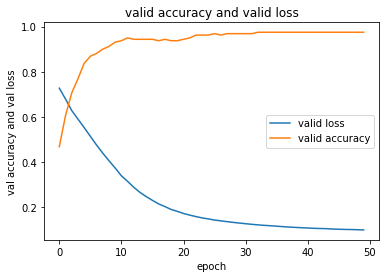

In [48]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('valid accuracy and valid loss')
plt.ylabel('val accuracy and val loss')
plt.xlabel('epoch')
plt.legend(['valid loss', 'valid accuracy'])
plt.show()


In [63]:
from sklearn.metrics import confusion_matrix

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', round(score[0], 3))
print('Test accuracy:', round(score[1], 3))

predictions = np.argmax(model.predict(X_test), axis=-1) 
cm = confusion_matrix(y_test[:,1], predictions)
print(cm)

X_test shape: (400, 20, 4)
y_test shape: (400, 2)
Test loss: 0.095
Test accuracy: 0.973
[[188   6]
 [  5 201]]


# using hyperopt

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
import hyperopt as ho


hyperparams = {'conv_width': [1], #stride
               'conv_filters': [5, 10], # hidden units
               'conv_layers': [2, 3], 
               'dense_layers': [1, 2],
               'conv_dropout': [None, 0.1],
               'dense_dropout': [None, 0.1],
               'dense_units': [32, 64],
               'kernel_size': [4, 5]
              }

space = {
    'conv_width': ho.hp.choice('conv_width', [1]),
    'conv_filters': ho.hp.choice('conv_filters', [5, 10]),
    'conv_layers': ho.hp.choice('conv_layers', [2, 3]),
    'dense_layers': ho.hp.choice('dense_layers', [1, 2]),
    'conv_dropout': ho.hp.choice('conv_dropout', [None, 0.1]),
    'dense_dropout': ho.hp.choice('dense_dropout', [None, 0.1]),
    'dense_units': ho.hp.choice('dense_units', [32, 64]),
    'kernel_size': ho.hp.choice('kernel_size', [4, 5]),
}


In [27]:
def create_model(params):
    model = Sequencial()
    model.add(Convolution2D(params['conv_filters'],
                            params['kernal_size'],
                            stride=params['conv_width'],
                            padding = "valid",
                            data_format = "channels_first",
                            input_shape = (20, 4),
                            activation = "relu"
                           ))
    
    if params['conv_dropout']:
        model.add(Dropout(rate = params['conv_dropout']))
        
    for i in range(params['conv_layers'] - 1):
        model.add(Convolution1D(params['conv_filters'],
                            5, ## kernel size
                            stride=params['conv_width'],
                            padding = "valid",
                            data_format = "channels_first",
                            input_shape = (20, 4),
                            activation = "relu"
                           ))

['__add__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 'arg',
 'clone_from_inputs',
 'define_params',
 'eval',
 'inputs',
 'name',
 'named_args',
 'o_len',
 'pos_args',
 'pprint',
 'pure',
 'replace_input',
 'set_kwarg']

In [49]:
from pandas import Series, DataFrame

genes = Series([0.1, 0.2, 1.4, 0.6, 1.1])
print(genes)

0    0.1
1    0.2
2    1.4
3    0.6
4    1.1
dtype: float64


In [50]:
genes = Series([0.1, 0.2, 1.4, 0.6, 1.1], index=['A', 'B', 'C', 'D', 'E'])
print(genes)

A    0.1
B    0.2
C    1.4
D    0.6
E    1.1
dtype: float64


In [54]:
x = np.array(
    [[[1, 2, 3],
      [2, 3, 4]],
     [[5, 6, 7],
      [8, 9, 10]],
     [[11, 12, 13],
      [14, 15, 16]]]
)
print(x.ndim)
print(x.shape)
print(x.dtype)

3
(3, 2, 3)
int64
